In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
from dismantling_code import *

In [3]:
%load_ext autoreload
%autoreload 2

# Simple Testing

Try generating a graph, and trying different methods to dismantle it.
You may find some visualization functions helpful:
 * draw_graph_with_nodes(G, nodes, node_size=100)
   * draw the graph G with nodes in the set `nodes` highlighted in red
 * draw_graph_ccs(G,node_size=100)
   * draw the graph G with different connected components highlighted in different colors.

In [4]:
G = nx.erdos_renyi_graph(100, 0.1)
# G = susc_generator(20, 2, p=0)
# G = nx.random_lobster(200, 0.15, 0.15)
for n in G.nodes:
    G.nodes[n]['node weight'] = 100 * (1 - random.randrange(0, 1))

for e in G.edges:
    u, v = e
    G.edges[e]['edge weight'] = G.nodes[u]['node weight'] + G.nodes[v]['node weight']

100
Number of nodes removed: 64
Nodes removed: {0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39, 41, 44, 45, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58, 59, 64, 65, 66, 71, 72, 73, 76, 78, 79, 81, 84, 88, 89, 91, 93, 94, 97}
------------
Removed 47 nodes from G.
Cost: 4700
Time elapsed: 0.157s
Nodes removed: [79, 60, 36, 11, 91, 83, 71, 63, 49, 89, 85, 1, 25, 7, 93, 76, 72, 32, 57, 38, 31, 97, 61, 50, 80, 69, 52, 48, 67, 35, 66, 65, 6, 94, 90, 13, 23, 39, 78, 16, 84, 86, 4, 95, 55, 18, 54]


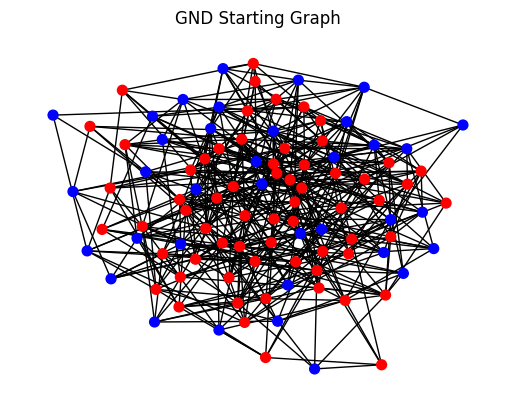

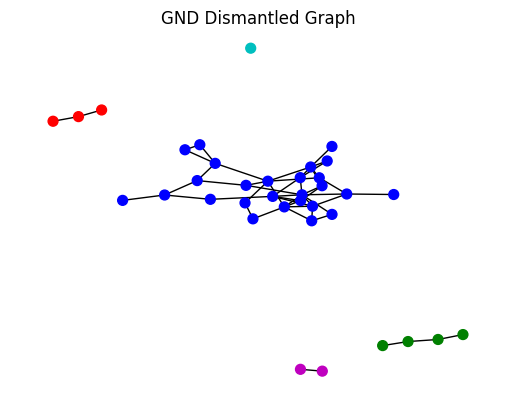

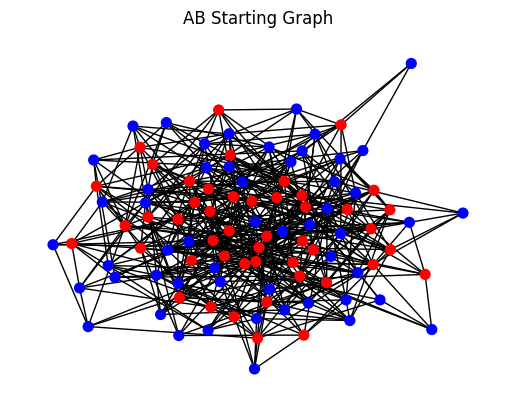

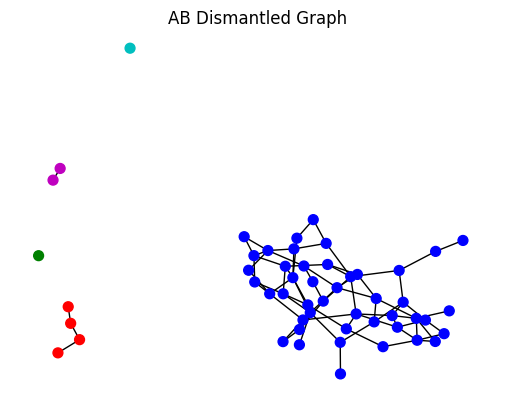

In [11]:
C = 50
node_size=50

## Compare GND against AB

S = gnd(G, C, verbose=False)
print(f"Number of nodes removed: {len(S)}")
print(f"Nodes removed: {S}")
plt.title(f"GND Starting Graph")
draw_graph_with_nodes(G, S, node_size=node_size)
plt.figure()
plt.title(f"GND Dismantled Graph")
g_c2 = G.copy()
g_c2.remove_nodes_from(S)
draw_graph_ccs(g_c2,node_size=node_size)
plt.figure()

print(f"------------")

S_ab, _ = greedy_algorithm(approximate_betweenness_centrality_cd, G, c=C / G.number_of_nodes())
print(f"Nodes removed: {S_ab}")
plt.title(f"AB Starting Graph")
draw_graph_with_nodes(G, S_ab,node_size=node_size)
plt.figure()
plt.title(f"AB Dismantled Graph")
g_c2 = G.copy()
g_c2.remove_nodes_from(S_ab)
draw_graph_ccs(g_c2,node_size=node_size)